# Project Intro
*Nicole Basinski, Nydia Chang, Danny Wan, Jason Xing*  
  
As part of the Erdos May Bootcamp 2022, we submit our project using gaze position data on Atari videogames, obtained from the [Atari-HEAD: Atari Human Eye-Tracking and Demonstration Dataset](https://zenodo.org/record/3451402#.YpEEB5PML0r).  
  
20 Atari games were played by 4 human players in a frame-by-frame manner to obtain gaze samples, as well as associated action taken by the player, current game score, among some other information. Semi-frame-by-frame gameplay allowed for the players to make near-optimal game decisions that led to scores in the range of known human records. Semi-frame-by-frame gameplay also resulted in more accurate game state and action associations (due to removing the effect of human reaction time); this resulted in more optimal data for any supervised learning algorithms.  

Regular trials were set to a 15-minute timeframe; highscore trials allowed the player to continue gameplay until they ran out of lives (up to a max of 2 hours). Each trial, whether regular or highscore, corresponds to a text file and a .tar.bz2 file. The text file recorded player actions, gaze positions, and other data for each frame during that trial, and the .tar.bz2 file includes .png images of each game frame.  
    
This project will use the game frames along with associated gaze positions to model the best resulting action. We focused on the Ms. Pacman game and specifically the `highscore` trials, largely for time and computational reasons. However, much of the cleaning, EDA, and modeling included in this repo would apply for other games and trials as well.

TO DO: MAYBE WANT TO PUT A SUMMARIZED VERSION OF OUR KPIS/STAKEHOLDERS HERE??

In [2]:
# imports
import shutil
from csv import reader

import numpy as np
import pandas as pd
import torch

/Users/nicolebasinski/.pyenv/versions/3.8.13/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cleaning Data
First step, we will clean the data into a workable format. The cells below will 1. clean the appropriate text files, 2. combine the cleaned text files into a single csv (named `combined_trial_data.csv`), 3. extract the appropriate images (placed in a single directory called `frames`), and 4. ravel the image data and place this information into a single csv (called `ravelled_image_data.csv`). Upon success of those steps, there is also a cell that removes the unneeded files from this directory to conserve space and memory. The functions in `utils/clean_data.py` could also be pulled out and adpated as needed.  

To run the cleaning scripts as written below, declare parameters based on the below descriptions.  
- `source_dir`: Str. By default, this is `raw_data`. This is the top-level directory for the script to look to for extracting the original data.
- `target_dir`: Str. By default, this is `cleaned_data`. This is the top-level directory where the script will place the cleaned form of each file from `raw_data`.
- `final_dir`: Str. By default, this is `final_data`. This is the top-level directory where the final forms of the combined clean data will be placed.
- `game_name`: Str. The name of the game data being cleaned. This is used to look into the correct game directory under `raw_data` (derived from the directory structure of the original data).
- `highscore`: Boolean. Whether or not these are highscore being cleaned. This only affects what directory to point to, as the highscore trial data and regular trial data are in the same format. 

After the below section of cells has been run, this will be the final directory structure of the cleaned data (made to imitate the original data directory structure):
```
erdos-project-2022--atari-HEAD
|___final_data
    |___{game_name}
        |   combined_trial_data.csv
        |   ravelled_image_data.csv
        |
        |___frames
        |   |   {image-1}.png
        |   |   {image-2}.png
        |   |   ...
        |
        |___highscore
            |   combined_trial_data.csv
            |   ravelled_image_data.csv
            |
            |___frames
                |   {image-1}.png
                |   {image-2}.png
                |   ...
```

In [2]:
# declare parameters
GAME_NAME = 'ms_pacman'
HIGHSCORE = True
SOURCE_DIR = 'raw_data'
TARGET_DIR = 'cleaned_data'
FINAL_DIR = 'final_data'

In [3]:
from utils.clean_data import clean_all_raw_data

In [8]:
# this could take a minute to run
# for reference, on the Ms Pacman highscore trials, this took ~55s
clean_all_raw_data(
    game_name = GAME_NAME,
    highscore = HIGHSCORE,
    source_dir = SOURCE_DIR,
    target_dir = TARGET_DIR,
    final_dir = FINAL_DIR,
)

In [8]:
## THIS CELL WILL DELETE THINGS
## This will retain everything in the `final_data` directory
##  but will delete all the other data files.
## Recommended to conserve memory and space, but you've been warned
shutil.rmtree('raw_data')
shutil.rmtree('cleaned_data')

## PCA
Seeing as we have images in this dataset (for the frames of gameplay), we'll start by using PCA to reduce these images down to the most important features, to save time and computation.

In [2]:
from utils.PCA import perform_PCA, save_pca_images

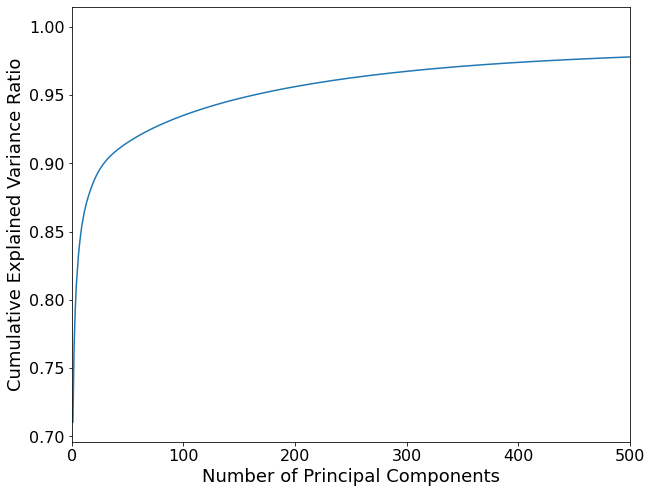

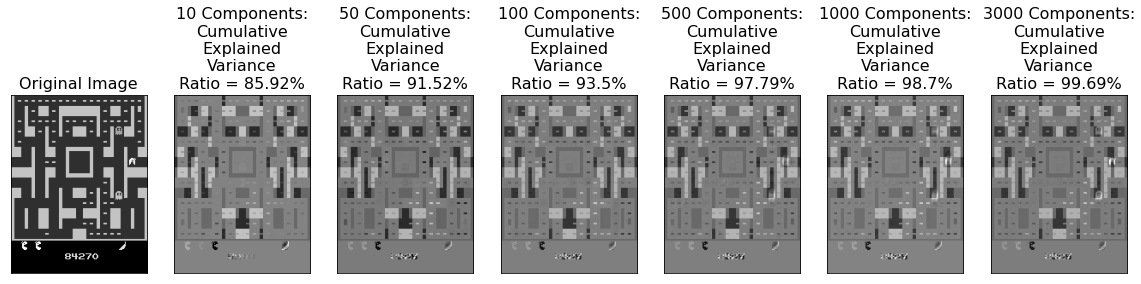

In [3]:
# might take some time
perform_PCA("final_data/ms_pacman/highscore/ravelled_image_data.csv")

In [3]:
save_pca_images(0.95, 
    read_filepath="final_data/ms_pacman/highscore/ravelled_image_data.csv",
    write_filepath="final_data/ms_pacman/highscore/pca_image_data.csv")

## EDA
TO DO

## Modeling
## Train Test Split
The first thing we will do is a train test split. The data is sequential, due to the frames of gameplay coming one after another. Thus, we will imitate a Time Series Split; the data is not set up for an out-of-the-box sklearn Time Series Split so we will manually split the data by the first 80% of frames and last 20% of frames. 

In [9]:
# pull in our cleaned, combined data csv
trial_text_df = pd.read_csv("final_data/ms_pacman/highscore/combined_trial_data.csv")

In [16]:
trial_1 = trial_text_df[trial_text_df['trial_id'] == '118_RZ']
trial_2 = trial_text_df[trial_text_df['trial_id'] == '593_RZ']

In [26]:
def get_num(row):
    frame_id = row['frame_id']
    splits = frame_id.split('_')
    return int(splits[2])

In [27]:
trial_1['frame_num'] = trial_1.apply(lambda x: get_num(x), axis=1)
trial_1.sort_values('frame_num', inplace=True)

trial_2['frame_num'] = trial_2.apply(lambda x: get_num(x), axis=1)
trial_2.sort_values('frame_num', inplace=True)

/var/folders/8y/j26pb55n2tj8f1q8rjsrjbxc0000gq/T/ipykernel_31670/2762301326.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_1['frame_num'] = trial_1.apply(lambda x: get_num(x), axis=1)
/var/folders/8y/j26pb55n2tj8f1q8rjsrjbxc0000gq/T/ipykernel_31670/2762301326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trial_1.sort_values('frame_num', inplace=True)
/var/folders/8y/j26pb55n2tj8f1q8rjsrjbxc0000gq/T/ipykernel_31670/2762301326.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [30]:
# some groupings to see just the fields we want for this model
df_1 = trial_1.groupby(['frame_id','action_int', 'frame_num']).agg({'gaze_position_x': 'median', 'gaze_position_y': 'median'})
df_1.columns = ['gaze_position_x_med', 'gaze_position_y_med']
df_1.reset_index(inplace=True)
df_1 = df_1[['frame_id', 'frame_num', 'gaze_position_x_med', 'gaze_position_y_med', 'action_int']].sort_values('frame_num')

df_2 = trial_2.groupby(['frame_id','action_int', 'frame_num']).agg({'gaze_position_x': 'median', 'gaze_position_y': 'median'})
df_2.columns = ['gaze_position_x_med', 'gaze_position_y_med']
df_2.reset_index(inplace=True)
df_2 = df_2[['frame_id', 'frame_num', 'gaze_position_x_med', 'gaze_position_y_med', 'action_int']].sort_values('frame_num')
df_2.head()

,frame_id,frame_num,gaze_position_x_med,gaze_position_y_med,action_int
0,RZ_5037271_1,1,60.290084,-85.818572,0
8450,RZ_5037271_2,2,59.578059,-84.970478,0
9555,RZ_5037271_3,3,68.306962,-79.318304,2
10661,RZ_5037271_4,4,82.373418,-68.215244,2
11769,RZ_5037271_5,5,82.310127,-68.207193,2


In [31]:
# split into train and test
# first 80% of frames for training, last 20% for testing

# trial 1
total_frames_1 = len(df_1)
train_len_1  = int(round(total_frames_1*0.8, 0))

df_train_1 = df_1[:train_len_1]
df_test_1 = df_1[train_len_1:]

# trial 2
total_frames_2 = len(df_2)
train_len_2 = int(round(total_frames_2*0.8, 0))

df_train_2 = df_2[:train_len_2]
df_test_2 = df_2[train_len_2:]

# combine trial 1+2 train and save
df_train = pd.concat([df_train_1, df_train_2])

# combine trial 1+2 test and save
df_test = pd.concat([df_test_1, df_test_2])

df_train.to_csv("final_data/ms_pacman/highscore/train_data.csv", index=False)
df_test.to_csv("final_data/ms_pacman/highscore/test_data.csv", index=False)

In [32]:
def get_rows_array(filepath):
  with open(filepath) as obj:
      csv_reader = reader(obj)
      rows_list = []
      img_ids = []
      for row in csv_reader:
          img_ids.append(row[0])
          rr = np.array([int(float(r)) for r in row[1:]])
          rows_list.append(rr)
  rows = np.array(rows_list)
  return rows, img_ids

class ErdosDataset(torch.utils.data.Dataset):
    """tabular and image dataset"""
    
    def __init__(self, image_path, train_path):
        self.rows, self.img_ids = get_rows_array(image_path)

        with open(train_path, 'rb') as f:
          self.X_train = pd.read_csv(f)

    def __len__(self):
        # we will return the number of bins
        return len(self.X_train)

    def __getitem__(self,index):
      """
      Returns the training example for the given index.
      Args:
      - index (int): index of the example to grab
      Returns:
      - img (numpy arr): Frame image with shape (210, 160, 3)
      - gaze_x (float): average x-coordinate for the given bin
      - gaze_y (float): average y-coordinate for the given bin
      - y (int): Integer value of the true class (action)
      """
      row = self.X_train[index] #Grab the data
      img_id = row['frame_id']
      gaze_x = row['gaze_position_x_med']
      gaze_y = row['gaze_position_y_med']
      y = row['action_int']

      image_arrs = self.rows
      image_ids = self.img_ids

      #Grab the image associated with img_idx
      img_index = image_ids.index(img_id)
      img = image_arrs[img_index]

      return img, gaze_x, gaze_y, y

## Appendix

**Citations:**  
  
Ruohan Zhang, Calen Walshe, Zhuode Liu, Lin Guan, Karl S. Muller, Jake A. Whritner, Luxin Zhang, Mary Hayhoe, & Dana Ballard. (2019). Atari-HEAD: Atari Human Eye-Tracking and Demonstration Dataset (Version 4) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.3451402